# Assignment Week 6 and 7 - Location Planning

In [87]:
import numpy as np
import pandas as pd
import random
import gurobipy as gp
from gurobipy import *
import matplotlib.pyplot as plt

In [88]:
# Loading necessary data
path_data = "../Advanced Data Science Data/"
df_incidents = pd.read_csv(path_data + "Incidents_11-05.csv")
df_candidates = pd.read_csv(path_data + "unique_candidates_11-05.csv")
d = np.load(path_data + "cost_matrix.npy")

In [89]:
# Filtering and organising data
df_incidents_fil = df_incidents[["dutch_rd_x", "dutch_rd_y", "type"]]
arr_incidents = df_incidents_fil[["dutch_rd_x", "dutch_rd_y"]].to_numpy()
arr_candidates = df_candidates[["first_point_x", "first_point_y"]].to_numpy()
d = np.reshape(d, (np.shape(arr_candidates)[0], np.shape(arr_incidents)[0]))

In [90]:
print(d.shape)
print(arr_incidents.shape)
print(arr_candidates.shape)

if d.shape[0] != arr_candidates.shape[0] or d.shape[1] != arr_incidents.shape[0]:
    raise ValueError("Dimensions do not match")

(1416, 678)
(678, 2)
(1416, 2)


In [91]:
display(np.where(d[0,:]!=10000000))

(array([ 14,  15,  19,  25,  26,  40,  46,  51,  53,  58,  71,  73, 111,
        121, 162, 177, 193, 216, 221, 224, 241, 253, 256, 257, 258, 260,
        263, 267, 269, 270, 290, 293, 309, 315, 320, 328, 344, 382, 387,
        390, 431, 450, 457, 497, 503, 505, 507, 538, 540, 544, 546, 552,
        554, 581, 583, 617, 618, 621, 633, 638, 639, 664, 667, 669, 670,
        672, 675], dtype=int64),)

In [107]:
print(d[0,np.where(d[0,:]<1e7)])

[[ 91924.  16420.  16420.  76080.  47864.  53412.  31795.  32072.  36487.
   24984.  16372.  16372. 104001. 104001. 108181. 108181. 179187. 179187.
   87539. 122005.  88453.  37700.  57600.  58155.  58155. 179187.  53590.
   54704. 110883.  57600.  41900.  41900.   2386. 118479.  53590. 118479.
   43884.  69034.  86079.  35663.  49956.  99804.  35663.  97454.  67062.
   67062.  33937.  67062.  19748.  19748.  15785.  92219. 201582.  35328.
   69034.  77436. 119989.  77436.  81378.  62270.  10759.]]


# Model

In [93]:
model = Model("Road inspectors")

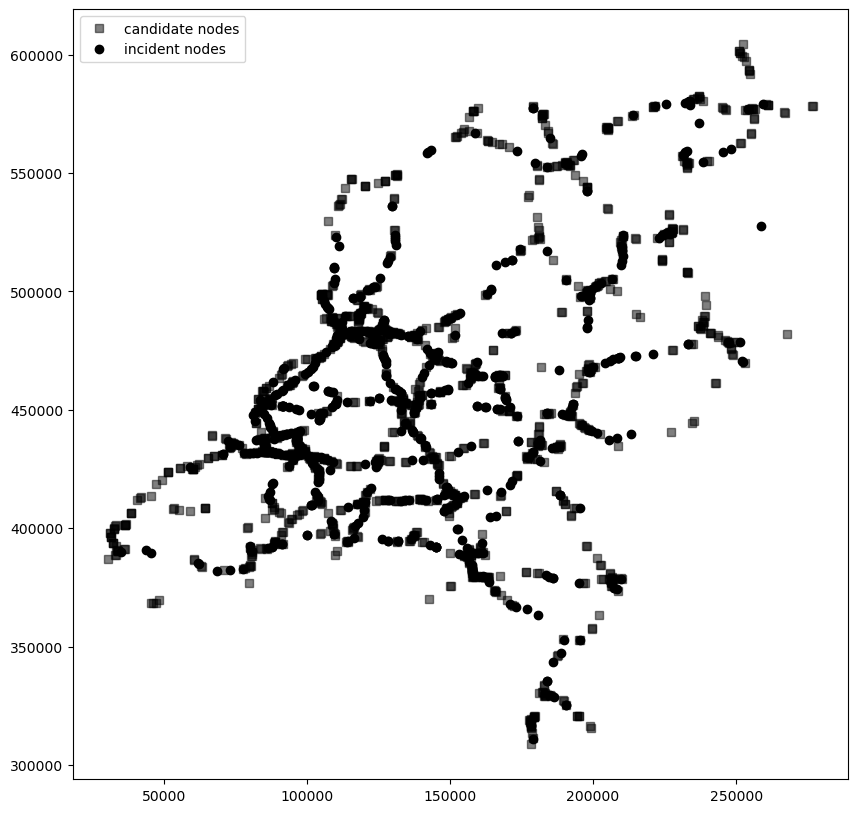

In [94]:
# np.random.seed(20)
# candidates = np.random.randint(0, 1000, (50, 2))
# incidents = np.random.randint(0, 1000, (25, 2))
candidates = arr_candidates
incidents = arr_incidents

plt.figure(figsize=(10, 10))
plt.plot(candidates[:, 0], candidates[:, 1], 'ks', alpha=0.5, label='candidate nodes')
plt.plot(incidents[:, 0], incidents[:, 1], 'ko', label='incident nodes')
plt.legend()

In [95]:
N = np.arange(candidates.shape[0])
K = np.arange(incidents.shape[0])
# M = 99999 # Big M
# Parameters
# d = np.ones(((N.shape[0], K.shape[0])), dtype=float) * M
# for i in range(N.shape[0]):
#     for k in range(K.shape[0]):
#         d[i, k] = np.sqrt(np.sum((candidates[i, :] - incidents[k, :]) ** 2))

inspector_cap = 10
N_inspectors = 800

In [96]:
pair = [(i, k) for i in N for k in K]
x = model.addVars(pair, vtype=GRB.BINARY, name="x")
c = model.addVars(N, vtype=GRB.BINARY, name="c")

model.Params.IntegralityFocus=0 
model.update()

In [97]:
model.setObjective(quicksum(d[i, k] * x[i, k] for i in N for k in K),
                   GRB.MINIMIZE)

In [98]:
model.addConstrs(quicksum(x[i, k] for i in N) == 1 for k in K);

In [99]:
model.addConstrs(quicksum(x[i, k] for k in K) <= inspector_cap * c[i] for i in N);

In [100]:
model.addConstr(quicksum(c[i] for i in N) <= N_inspectors);

In [101]:
model.update()

In [102]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2095 rows, 961464 columns and 1922928 nonzeros
Model fingerprint: 0x536047ee
Variable types: 0 continuous, 961464 integer (961464 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e+01, 1e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]
Found heuristic solution: objective 8.393060e+09
Presolve time: 2.40s
Presolved: 2095 rows, 961464 columns, 1922928 nonzeros
Variable types: 0 continuous, 961464 integer (961464 binary)
Found heuristic solution: objective 9.344192e+08
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 9.615e+05
 Factor NZ  : 2

In [103]:
# Print selected facilities
inspectors = []

for i in N:
    for k in K:
        if x[i, k].x == 1:
            inspectors.append(i)
inspectors = np.unique(inspectors)
print('Selected inspectors are nodes '+ str(inspectors))

Selected inspectors are nodes [   0    1    2    6    7   10   12   17   20   28   42   47   59   61
   63   65   68   69   74   76   85   88   89   98  101  103  107  113
  114  117  120  121  137  140  143  144  145  146  147  153  156  160
  165  172  174  177  178  179  181  186  188  200  201  203  204  206
  207  208  210  223  233  236  237  240  244  247  253  257  261  284
  289  292  297  306  307  308  328  329  342  344  347  351  356  361
  368  369  370  373  375  377  378  392  396  397  411  416  417  419
  420  421  426  427  436  451  454  461  470  472  474  476  478  480
  483  496  497  499  500  503  507  516  519  524  526  529  532  538
  542  548  551  552  556  557  563  568  570  575  578  587  589  604
  605  606  609  615  619  620  625  632  636  640  641  643  646  650
  653  657  668  682  685  693  694  704  705  707  713  714  716  717
  719  731  732  733  738  747  755  757  771  776  777  778  780  785
  786  796  797  798  799  803  804  806  811  

In [104]:
print(f'Minimum total cost is {model.ObjVal:.2f} km')
print(f'Number of inspectors is {len(inspectors)}')
print(f'Average distance per inspector {model.ObjVal / len(inspectors) :.2f} km')

Minimum total cost is 573017653.00 km
Number of inspectors is 319
Average distance per inspector 1796293.58 km


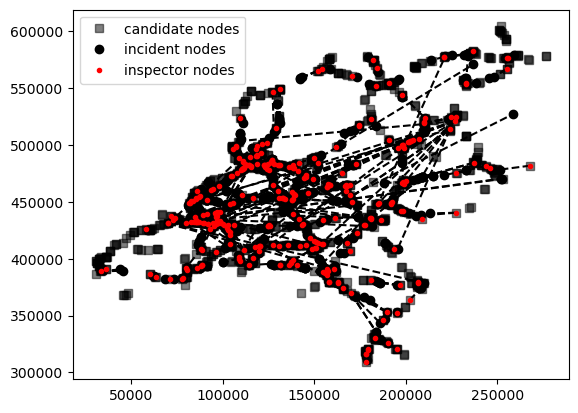

In [105]:
inspector_coordinate = np.zeros((len(inspectors), 2))

for i in range(len(inspectors)):
    inspector_coordinate[i, :] = candidates[inspectors[i], :]
    
for i in N:
    for k in K:
        if x[i, k].x == 1:
            plt.plot((candidates[i, 0], incidents[k, 0]),
                    (candidates[i, 1], incidents[k, 1]),
                    c='black', linestyle='--')

plt.plot(candidates[:, 0], candidates[:, 1], 'ks', alpha=0.5, label='candidate nodes')
plt.plot(incidents[:, 0], incidents[:, 1], 'ko', label='incident nodes')
plt.plot(inspector_coordinate[:, 0], inspector_coordinate[:, 1], 'r.', label='inspector nodes')
plt.legend()